In [12]:
import numpy as np
import pandas as pd
import scanpy as sc

In [13]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.1


In [14]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [15]:
adata = sc.read_10x_mtx(
    'data/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

... reading from cache file cache/data-hg19-matrix.h5ad


In [16]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


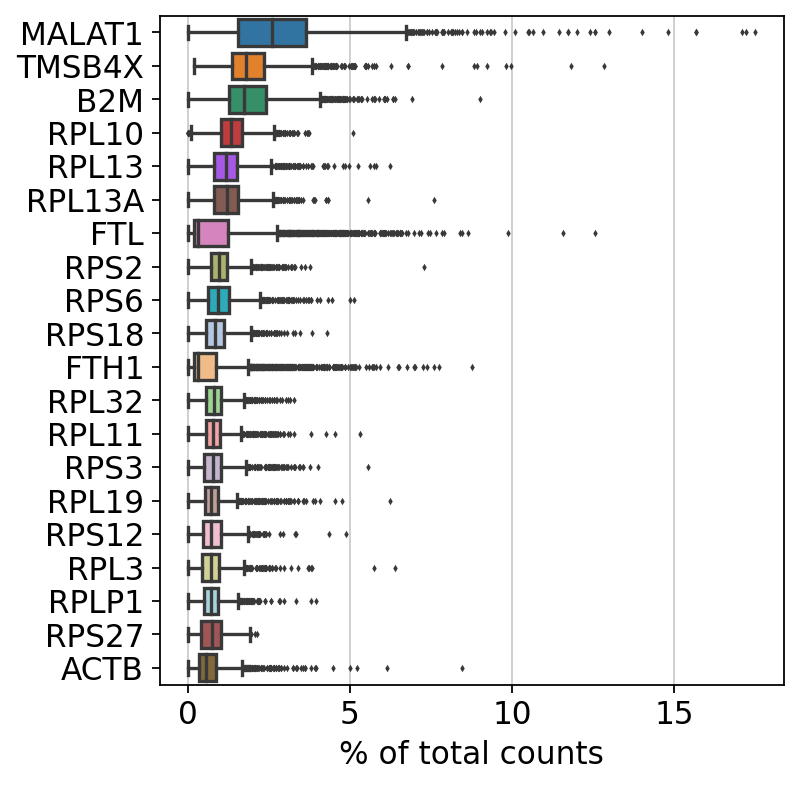

In [17]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [18]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [19]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/lib/python3.8/site-packages/seaborn/_core.py

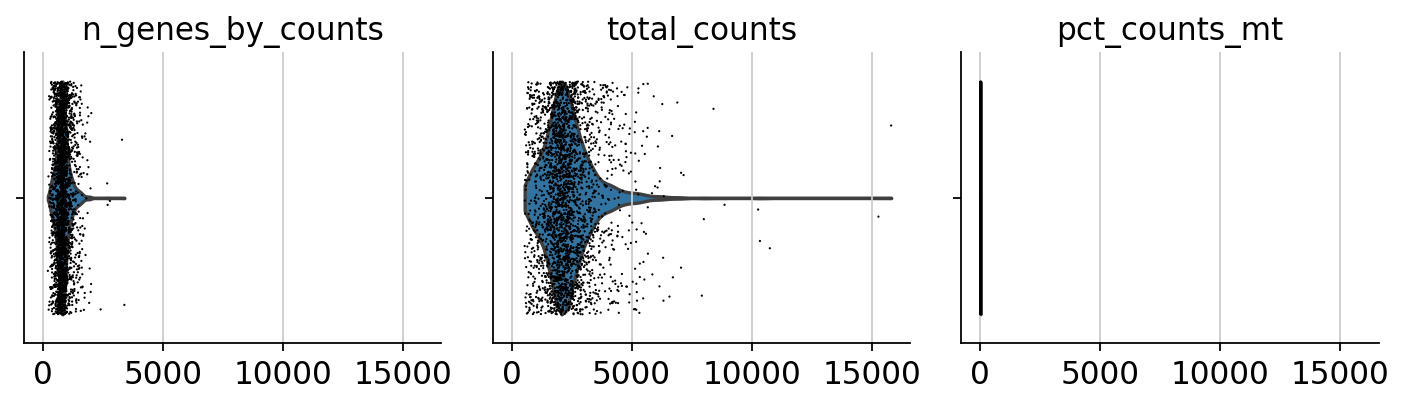

In [20]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

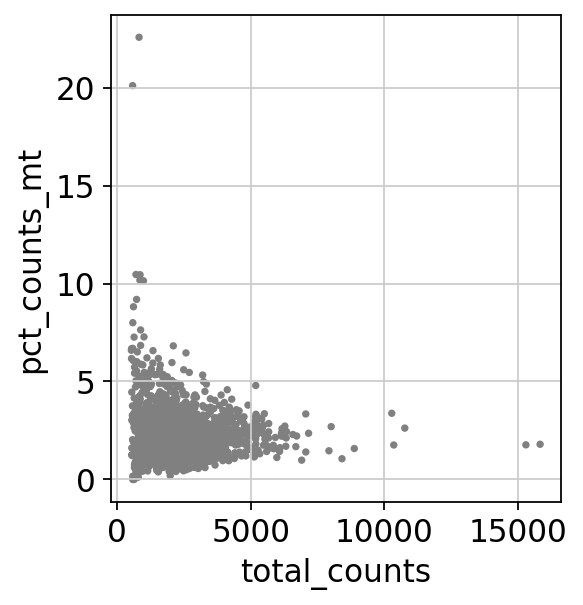

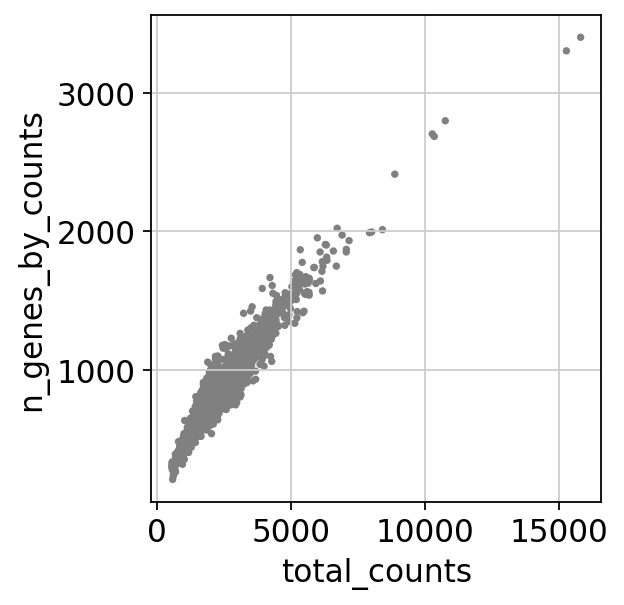

In [21]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [22]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [23]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [24]:
sc.pp.log1p(adata)

In [25]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


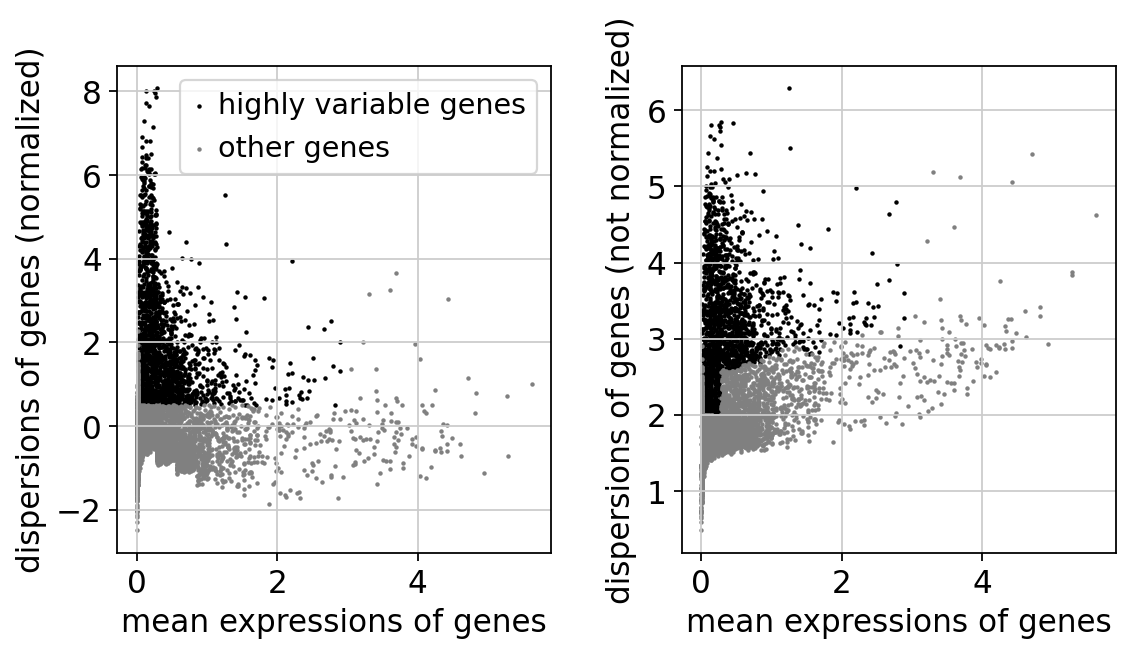

In [26]:
sc.pl.highly_variable_genes(adata)

In [27]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [44]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


In [47]:
adata.obs_keys()

['n_genes',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_mt',
 'pct_counts_mt']

In [45]:
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


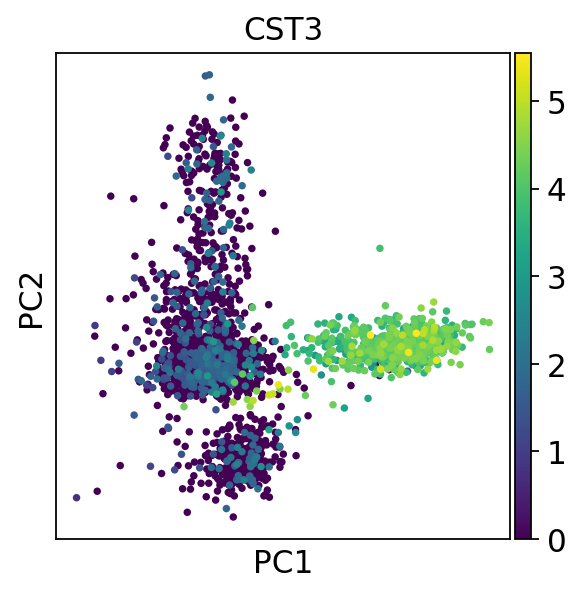

In [46]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

In [50]:
keys = ['total_counts', 'pct_counts_mt']
pd.api.types.is_categorical_dtype(adata.obs[keys[0]])

False

In [51]:
regressors = adata.obs[keys]
regressors.insert(0, 'ones', 1.0)

In [52]:
regressors

,ones,total_counts,pct_counts_mt
AAACATACAACCAC-1,1.0,2419.0,3.017776
AAACATTGAGCTAC-1,1.0,4903.0,3.793596
AAACATTGATCAGC-1,1.0,3147.0,0.889736
AAACCGTGCTTCCG-1,1.0,2639.0,1.743085
AAACCGTGTATGCG-1,1.0,980.0,1.224490
...,...,...,...
TTTCGAACTCTCAT-1,1.0,3459.0,2.110436
TTTCTACTGAGGCA-1,1.0,3443.0,0.929422
TTTCTACTTCCTCG-1,1.0,1684.0,2.197150
TTTGCATGAGAGGC-1,1.0,1022.0,2.054795
